# Measured space: energy and the Compton Data Space

In this tutorial, we'll calculate the basic event parameters that will allow us to do spectroscopy and imaging and will see how the measured data space looks like.

First, let's import some libraries and initialize our traditional detector (COMPTELito) from the previous tutorial:

In [1]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u

det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

Let's run some sims again, but this time let's simulate something closer to what an astrophysical source looks like. They are so far that the photons come to us as plane waves. Although all photons from a point source that reached the detector have nearly the same direction, they arrive at different positions on the detector.

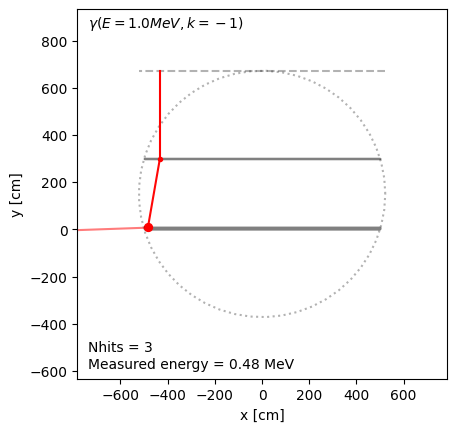

In [2]:
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum

# This is the location of the source in the detector coordinates.
# In COSI we call it "Nu", but since we live in a 3D world, 
# we need a second coordinate, which we call "Lambda".
source_offaxis_angle =  0*u.deg

# For simplicity, we'll simulate a mono-energetic source
source_energy = 1*u.MeV

source = PointSource(offaxis_angle = source_offaxis_angle,
                     spectrum = MonoenergeticSpectrum(source_energy))

# All photons from a mono-energetic point source have the 
# same energy and direction, but arrived at different locations
# random_photo() get this position at random 
primary = source.random_photon(detector = det)

# See below for a description of the surrounding circle and throwing plane
sim_event = det.simulate_event(primary)
det.plot(event = sim_event,
         draw_surrounding_circle = True);

This time we set `draw_surrounding_circle = True`, which will draw a circle that fully encloses the detector --which would be a sphere in our 3D world-- as well as a straight line (the "throwing plane" in 3D) that has the same length as the surrounding circle's diameter, and perpendicular to the direction of the photon. 

<div class="alert alert-block alert-info">
<b>Exercise: </b>
    
- Run the previous cell multiple times to get a feeling for how the simulations work.
- Try changing the off-axis angle of the source.
</div>


We use the surrounding sphere to avoid simulating too many photons that have no chance of interacting with the detector while still keeping the thrown plan area the same for all directions, allowing us to correctly normalize the flux. Given the total photon flux of a source and the duration of the observations, we can compute the total number of events from a source in our thrown plane as:

In [3]:
flux = 1/u.cm/u.s # Unit of 1/u.cm/u.s in flatland, 1/u.cm/u.cm/u.s in our world!
duration = 1*u.s
nsim = flux*duration*det.throwing_plane_size

# One extra step to remove the units
# nsim is already unitless, we just need this due to how astropy 
# tracks the units. See for yourself:
# print(f"Before extra step: {nsim}")
nsim = nsim.to_value(u.dimensionless_unscaled)

print(f"We need to throw ~{nsim:.1f} events "
      f"at our surrounding sphere of size {det.throwing_plane_size:.2f} "
      f"in order to simulate a source with flux={flux} "
      f"over an observation duration of {duration}")

We need to throw ~1044.0 events at our surrounding sphere of size 10.44 m in order to simulate a source with flux=1.0 1 / (cm s) over an observation duration of 1.0 s


## Measured energy

Now, let's see how many of these triggered our detector. From the discussion in the last tutorial, a reasonable simple set of event trigger conditions are:
- At least one hit in the top layer (the 0-th layer)
- At least one hit in the bottom layer (which is really a group of thin layers)
- The first hit occurred in the top layer

Let's simulate a bunch of events, applying our trigger condition and attempting to estimate the energy of the primary by summing up all the hit energies. We'll keep track of them in a histogram.

100%|██████████| 1044/1044 [00:15<00:00, 65.71it/s] 


(0.1, 2)

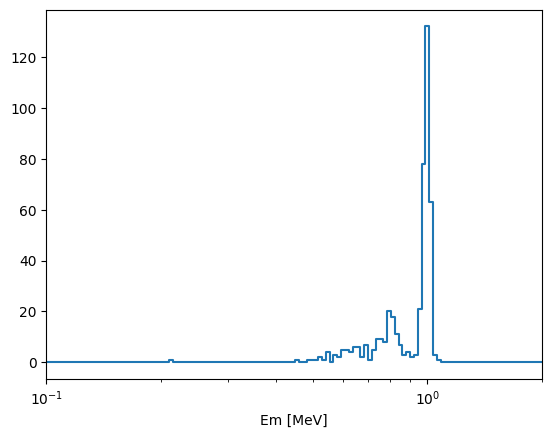

In [4]:
# Import
from histpy import Histogram, Axis
from tqdm import tqdm # For the impatient

# Histogram to keep track of the measured energy
h_Em = Histogram(Axis(np.geomspace(.1,10,200)*u.MeV, label = "Em", scale = 'log'))

# Simulate events
for i in tqdm(range(int(np.round(nsim)))):

    # Get a random gamma ray
    primary = source.random_photon(det)
    
    # Simulate the interaction with the detector
    sim_event = det.simulate_event(primary)

    # Get all hits. Each has a position and a deposited energy
    hits = sim_event.hits

    # Trigger condition described in the cell above
    triggered = hits.nhits >= 2 and hits.layer[0] == 0
    
    if not triggered:
        # Didn't meet our trigger condition
        continue

    # The energy of the primary is estimated based on the sum of all hits 
    measured_energy = np.sum(hits.energy)

    # Add to histogram
    h_Em.fill(measured_energy)

# Plot
ax,_ = h_Em.plot()

ax.set_xlim(.1,2)

We can see two main features
1. The large peak centered at the thrown energy (1 MeV in our case). This is called the photopeak. The events within this peak were, for the most part, fully absorbed within the detector. The non-zero width is caused by the finite energy resolution. In addition, if you look closely, you'll see that photopeak is not assymetric, due to some event for which a little bit of their energy scaped or had hits below the detectable energy threshold.
2. The much broader feature at lower energies is usually called the Compton continuum or shoulder. The right-hand side of the continuum is called the Compton edge. This is caused by events that largely escaped the detector. The location of the Compton edge is approximately the maximum energy that a photon can transmit to an electron on a single interaction. Based on the Compton kinematic equation this happens for a backscattered event, and the transferred energy is:

$$E_{edge} = E \left(1 - \frac{1}{1+\frac{2E}{m_e c^2}}\right)$$ 

For $E = 1 MeV$, $E_{edge} = 0.796 MeV$

Now, let's see how many events we detected:

In [5]:
ntrig = np.sum(h_Em)
print(ntrig)

450.0


Our efficiency is:

In [6]:
eff = ntrig/nsim

print(f"Efficiency = {eff:.2f}")

Efficiency = 0.43


We can use it to estimate the effective "area" of our detector --or rather, effective "length", since we are in flatland, I guess, but bear with me. That is:

In [7]:
Aeff = det.throwing_plane_size * eff

print(f"Effective \"area\" = {Aeff:.2f}")

Effective "area" = 4.50 m


Alternatively, we can estimate the effective area based on the simulated flux and duration:

In [8]:
ntrig / flux / duration 

<Quantity 450. cm>

Note that the effective area depends on a particular direction, energy, and trigger condition. Make sure to get all this information to correctly interpret the effective area.

The width of the photopeak is typically quoted as the energy resolution. You can measure it by e.g. fitting it to a Gaussian, but for now, by eye, it's about 50 keV. Sometimes we're interested in knowing the effective area given only the event for which we precisely measured the energy, that is, the "photopeak effective area". In that case, we only select the events within the photopeak:

In [9]:
photopeak_width = 50*u.keV # Approximate 1 sigma, by eye
ntrig_photo = np.sum(h_Em.contents[(h_Em.axis.centers < source_energy + 3*photopeak_width) &
                      (source_energy - 3*photopeak_width < h_Em.axis.centers)])

Aeff_photo = ntrig_photo / flux / duration 

print(f"Photopeak effective area = {Aeff_photo:.2f}")

Photopeak effective area = 317.00 cm


<div class="alert alert-block alert-info">
<b>Exercise:</b>
    
- Set the energy resolution and threshold to 0. That is a "perfect" detector. What improved and what didn't? Why are not all events within photopeak?
- Vary the injected energy and compute the effective area. Plot the effective area vs energy and estimate the energy range. What limits the effective area at low energies? What about the high energies?
- How does the energy range vary as a function of the off-axis angle? Why?
</div>


## The Compton Data Space (CDS)

As you have seen by playing with Compton detectors from the previous tutorial, due to the large scattering angles in a Compton interaction, the direction of the scattered gamma ray is not a very good estimate of the direction of the incoming gamma ray. 

While the scattered gamma ray does not point back at the source, not all is lost. The saving grace is that, without knowing the direction of the primary, we can measure the scattering angle purely from kinematics! Here's the Compton scattering equation again:

$$E_{\gamma}^\prime = \frac{E_\gamma}{1 + (E_\gamma/m_e c^2)(1-\cos\phi)}$$

You can see that we can solve for $\phi$ if we're able to measure:
1. The total energy of the incoming gamma ray --i.e. $E_{\gamma}$.
2. The energy deposited in the first interaction --i.e. $E_{\gamma}^\prime = E_{\gamma} - \Delta E_{first}$

Let's see how this works in practice by simulating a monoenergetic (1 MeV) point source placed along the axis of the detector. In flatland we need a single angle to describe the direction of the scattered gamma-ray, we'll call it $\psi$. This is equivalent to the coordinate $\psi\chi$ in 3D.

In [10]:
# Imports
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum

# Setup an on-axis monoenergetic source
source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = MonoenergeticSpectrum(1*u.MeV))

# Hitogram with our full data space (except time): measured energy + CDS
h_data = Histogram([Axis(np.linspace(0,2,200)*u.MeV, label = 'Em'),
                    Axis(np.linspace(0,180, 180)*u.deg, label = 'Phi'),
                    Axis(np.linspace(-180,180, 360)*u.deg, label = 'Psi')])

# Simulate event
for i in tqdm(range(int(np.round(nsim)))):

    #=== This is the same as the Em-only example above ====
    primary = source.random_photon(detector = det)
    
    sim_event = det.simulate_event(primary, doppler_broadening = False)

    hits = sim_event.hits

    triggered = hits.nhits >= 2 and hits.layer[0] == 0
    
    if not triggered:
        # Didn't meet our trigger condition
        continue

    measured_energy = np.sum(hits.energy)
    #===============
    
    # Compton Data Space calculation

    # Get the energy and position of each hit, top and bottom
    
    # Get the first interaction (top layer)
    # Remember that the layers have enough separation that
    # we know which hit was the first one based on timing
    energy_top = hits.energy[0]
    position_top = hits.position[0]
    
    # The bottom layer acts as a calorimeter which doesn't have
    # a very good position resolution. We average the location
    # of the hits from each of the "sublayers" we used to
    # simulate it.
    position_bottom = np.mean(hits.position[hits.layer > 0])

    # Compute E_{\gamma}^\prime
    energy_out = measured_energy - energy_top
    
    # Compute the scattering angle by solving the Compton equation
    # Note that the position measurements play no part in this
    # calculation. It's based on the energy measurements only.
    # We assume that measured_energy = E_\gamma
    cos_phi = 1 + 510.99*u.keV*(1/measured_energy - 1/energy_out)
    
    if cos_phi < -1:
        # Unphysical, likely due to a measurement error. Filter out
        continue
    
    phi = np.arccos(cos_phi)
        
    # Compute the direction of the scattered gamma ray
    # Note that the energy measurements play no part in this
    # calculation. It's based on the position measurements only.
    psi = -np.arctan2(position_bottom.x - position_top.x,
                      position_top.y - position_bottom.y)
    
    # Add to histogram
    h_data.fill(measured_energy, phi, psi)

100%|██████████| 1044/1044 [00:15<00:00, 67.91it/s]


The Compton Data Space look like this:

(<Axes: xlabel='Psi [deg]', ylabel='Phi [deg]'>,
 <matplotlib.collections.QuadMesh at 0x129e57e30>)

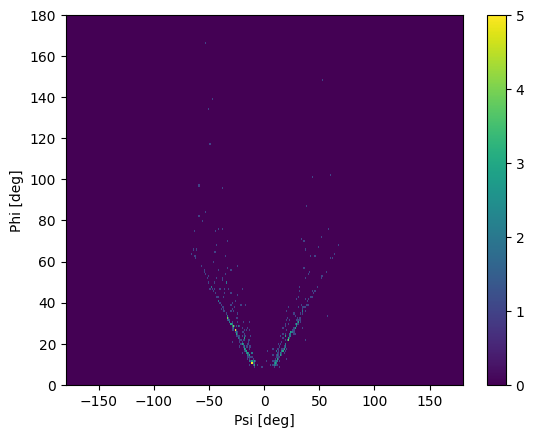

In [11]:
h_CDS = h_data.project('Psi','Phi')

h_CDS.plot()

In our 2D world, the distribution of the events on Compton data space falls along two perpendicular lines --question: why do they make 90 deg between them?-- that meet at the direction of the source. In 3D we need an extra angle to describe the direction, the $\{\phi, \psi\chi\}$ space, where the distribution becomes a cone with the vertex located at the source location and a full opening angle of 90deg. I'll keep calling it a cone even though we're in Flatland.

This is how a point source looks as measured by our detector. This is called the "point source response" (PSF).

<div class="alert alert-block alert-info">
<b>Exercise: Play time!</b>
    
- Vary the source direction (off-axis angle in flatland) and see how that affects the Compton cone. 
    - If you look only at the data, can you tell where the source is by eye? Can you see why it is critical to determine the phi from kinematics alone? 
    - Why is the cone asymmetric, even though we have the same number of left and right chiralities? This is equivalent to the instrumental-induced "unpolarized modulation pattern" we see in 3D.
- Vary the energy and see how that affects the Compton cone. Why is a large portion of the tip missing? 
- Estimate the effective area as a function of the off-axis angle. Does it vanish at some point? Can you detect upward-going events?
- The point source class has the options `chirality` --1 or -1-- and `chirality_degree` --between 0 to 1, the fraction between the events that have a defined chirality and those equally likely to be left or right. This is akin to polarization angle and polarization degree in 3D. Try different chiralities, with a 100% chirality degree. Can you tell why it is important to collect high scattering angles to measure the polarization angle and the polarization degree? You can try slicing along a given range of $\phi$ bins and project into $\psi$ --e.g. `h_data.slice[:,40:,:].project('Psi')`, and then see the difference between left and right of the source location --i.e. $\nu$
</div>

As you can see, not all the events fall exactly along the cone. Instead, the walls of the cone have some thickness. This is caused by a combination of the following measurement errors:
- Uncertainty in the hit position
- Uncertainty in the hit energy
- Error in the primary energy estimation due to events that left the detector without depositing all of their energy --called uncontained events. If we can't get the energy of the primary correctly, we're bound to get the scattering angle wrong when we use the Compton kinematic equation.
- Uncertainty in target electron state. When we use the Compton kinematic equation we assume that the target electrons are at rest and unbound. Neither of these is true since the electrons are bound to the material. The unknown electron state propagates into an error on the scattering angle. This is known as Compton broadening, and puts a [fundamental limit of ~1deg in the angular of a Compton telescope](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/4851/0000/Doppler-broadening-as-a-lower-limit-to-the-angular-resolution/10.1117/12.461177.short#_=_). 

The distribution of the deviations from the cone is called the "angular resolution measured" (ARM). This is defined as the difference between the measured $\phi$ angle, and the implied angle $\phi_{geo}$ based on the assumed source position --known from simulation-- and the scattering direction $\psi$. This is how it looks:

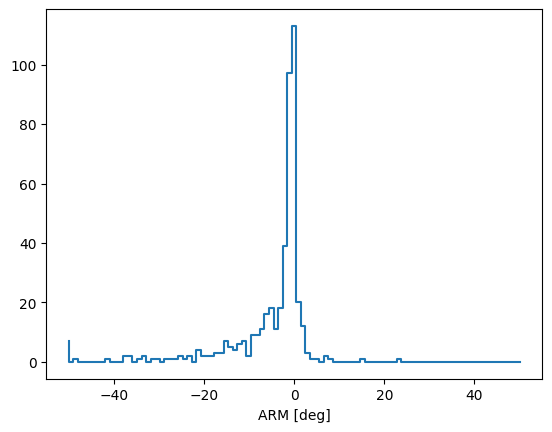

In [12]:
h_ARM = Histogram(np.linspace(-50,50,100)*u.deg, labels = 'ARM')

for nphi,phi in enumerate(h_CDS.axes['Phi'].centers):
    for npsi,psi in enumerate(h_CDS.axes['Psi'].centers):
        
        # This is how the ARM is computed.
        # Some conventions use the negative of this value instead
        arm = np.abs(psi - source.offaxis_angle) - phi 
        
        h_ARM.fill(arm, weight = h_CDS[{'Phi':nphi, 'Psi':npsi}])

h_ARM.plot();

This distribution is not symmetric. The excess on the left tail is caused mainly by uncontained events and could be removed if we had a way to identify and filter them out. In addition, the main peak is not Gaussian, and the tail can extend quite far. Since the flux ratio between a bright and a dim source can easily be a factor of order 100, it is important to model the tails appropriately.

The width of the ARM distribution is usually quoted as the angular resolution of the instrument. Even though the real PSF lives in the full CDS, and the thickness of the cone wall varies as a function of scattering angle, sometimes people quickly refer to the ARM distribution or its width as "the PSF" for convenience.  

## Putting it all together

The code above was packaged into various classes for convenience. The cell bellow has all the elements you need to simulate a source. These are the equivalent steps in MEGAlib:
- ToyTracker2D -> Geomega and the detector effects engine.
- PointSource -> The source file
- SimpleTraditionalReconstructor -> Revan
- Simulator -> Cosima

100%|██████████| 1000/1000 [00:41<00:00, 24.05it/s]


We simulated 1.0 s (3142 events) and detected 1000


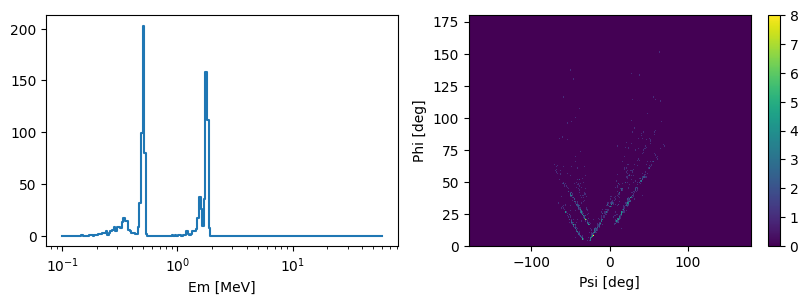

In [13]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum
import matplotlib.pyplot as plt

# Detector 
det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

# Sources
source_1 = PointSource(offaxis_angle = -10*u.deg,
                       spectrum = MonoenergeticSpectrum(511*u.keV),
                       flux = 2/u.cm/u.s)

source_2 = PointSource(offaxis_angle = -30*u.deg,
                       spectrum = MonoenergeticSpectrum(1.8*u.MeV),
                       flux = 1/u.cm/u.s)

# Getting Em and the CDS
reco = SimpleTraditionalReconstructor()

# Sims
sims = Simulator(detector = det, 
                 sources = [source_1, source_2], 
                 reconstructor = reco)

h_data = sims.run_binned(ntrig = 1000)

# Summary and plot
print(f"We simulated {sims.duration:.2} ({sims.nsim} events) and detected {sims.ntrig}")
fig,ax = plt.subplots(figsize = [10,3], ncols = 2)
h_Em = h_data.project('Em')
h_CDS = h_data.project('Psi','Phi')

h_Em.plot(ax[0])
h_CDS.plot(ax[1]);

<div class="alert alert-block alert-info">
<b>Exercise: Slicing the full measured data space</b>
    
- One way to disentangle sources is based on their spectrum. Take `h_data`, slice it along `Em`, and project it onto the CDS to select only one of the two sources above. 
- Try selecting just the photopeak. Does this change how the CDS looks compared to a selection that includes the Compton edge? Do you see any advantage to keeping the full Em+CDS as opposed to working with Em and CDS projections?
</div>